In [ ]:
# STEP 1: Upload GCP credentials
from google.colab import files
uploaded = files.upload()  # Upload your onion11-key.json

# STEP 2: Set up environment and download from GCS
import os
json_filename = list(uploaded.keys())[0]
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = json_filename
print(f"✅ Using GCP service account: {json_filename}")

GCS_URI = "gs://onion11"
!mkdir -p OnionData
!gsutil -m cp -r {GCS_URI}/* OnionData/

Streaming output truncated to the last 5000 lines.
Copying gs://onion11/BR_E5_P3_S_0582_FEB_7.JPG...
Copying gs://onion11/BR_E5_P3_S_0582_FEB_7.txt...
Copying gs://onion11/BR_E5_P3_S_0583_FEB_7.JPG...
Copying gs://onion11/BR_E5_P3_S_0583_FEB_7.txt...
Copying gs://onion11/BR_E5_P3_S_0694__FEB_8.JPG...
Copying gs://onion11/BR_E5_P3_S_0694__FEB_8.txt...
Copying gs://onion11/BR_E5_P3_S_0695__FEB_8.JPG...
Copying gs://onion11/BR_E5_P3_S_0695__FEB_8.txt...
Copying gs://onion11/BR_E5_P3_S_0735_FEB_9.JPG...
Copying gs://onion11/BR_E5_P3_S_0735_FEB_9.txt...
Copying gs://onion11/BR_E5_P3_S_0736_FEB_9.JPG...
Copying gs://onion11/BR_E5_P3_S_0736_FEB_9.txt...
Copying gs://onion11/BR_E5_P3_S_0787__FEB_14.JPG...
Copying gs://onion11/BR_E5_P3_S_0787__FEB_14.txt...
Copying gs://onion11/BR_E5_P3_S_0788__FEB_14.JPG...
Copying gs://onion11/BR_E5_P3_S_0788__FEB_14.txt...
Copying gs://onion11/BR_E5_P3_S_0832__FEB_14.JPG...
Copying gs://onion11/BR_E5_P3_S_0832__FEB_14.txt...
Copying gs://onion11/BR_E5_P3_S_0

In [ ]:
# STEP 3: Data preprocessing (same as CoatNet)
import shutil, random, warnings
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = 'OnionData'
class_id_to_name = {}
classes_txt_path = os.path.join(base_dir, 'classes.txt')
if os.path.exists(classes_txt_path):
    with open(classes_txt_path, 'r') as f:
        for i, line in enumerate(f):
            class_id_to_name[str(i)] = line.strip()

jpgs = {os.path.splitext(f)[0]: f for f in os.listdir(base_dir) if f.endswith('.jpg')}
txts = {os.path.splitext(f)[0]: f for f in os.listdir(base_dir) if f.endswith('.txt')}
paired = [base for base in jpgs if base in txts]

class_to_images = {}
for base in paired:
    txt_path = os.path.join(base_dir, txts[base])
    try:
        with open(txt_path, 'r') as f:
            line = f.readline().strip()
            if not line:
                continue
            class_id = line.split()[0]
            class_label = class_id_to_name.get(class_id, f"class_{class_id}")
            class_to_images.setdefault(class_label, []).append(jpgs[base])
    except Exception as e:
        print(f"Skipping {txt_path} due to error: {e}")

for split in ['train', 'val', 'test']:
    shutil.rmtree(split, ignore_errors=True)
    for label in class_to_images:
        os.makedirs(os.path.join(split, label), exist_ok=True)

for label, images in class_to_images.items():
    random.shuffle(images)
    total = len(images)
    train_n = int(0.8 * total)
    val_n = int(0.1 * total)
    test_n = total - train_n - val_n
    for img in images[:train_n]:
        shutil.copy(os.path.join(base_dir, img), os.path.join('train', label, img))
    for img in images[train_n:train_n+val_n]:
        shutil.copy(os.path.join(base_dir, img), os.path.join('val', label, img))
    for img in images[train_n+val_n:]:
        shutil.copy(os.path.join(base_dir, img), os.path.join('test', label, img))

In [ ]:
# 4. Data generators with augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    shear_range=0.1,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory('train', target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical')
val_generator = val_test_datagen.flow_from_directory('val', target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical')
test_generator = val_test_datagen.flow_from_directory('test', target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical')

num_classes = len(train_generator.class_indices)
class_labels = list(train_generator.class_indices.keys())

Found 866 images belonging to 6 classes.
Found 106 images belonging to 6 classes.
Found 113 images belonging to 6 classes.


In [ ]:
# 5. Define ViT model with frozen base
!pip install -q transformers
from transformers import TFAutoModel
import tensorflow as tf
from tensorflow.keras import layers, Model

class ViTLayer(layers.Layer):
    def __init__(self):
        super(ViTLayer, self).__init__()
        self.vit = TFAutoModel.from_pretrained('google/vit-base-patch16-224')
        self.vit.trainable = False  # Freeze pretrained layers

    def call(self, inputs):
        inputs = tf.transpose(inputs, [0, 3, 1, 2])
        return self.vit(pixel_values=inputs).last_hidden_state

def create_vit_model(num_classes):
    inputs = layers.Input(shape=(224, 224, 3))
    vit_outputs = ViTLayer()(inputs)
    pooled = layers.GlobalAveragePooling1D()(vit_outputs)
    x = layers.Dense(512, activation='relu')(pooled)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return Model(inputs, outputs)

model = create_vit_model(num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing TFViTModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTModel were not initialized from the PyTorch model and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vi_t_layer_1 (ViTLayer)         │ (None, 197, 768)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 768)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 396,806 (1.51 MB)

 Trainable params: 396,806 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 6. Train model with EarlyStopping and ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3)

import time
start_time = time.time()
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stop, lr_scheduler]
)
training_time = time.time() - start_time

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 116s 4s/step - accuracy: 0.9309 - loss: 0.1774 - val_accuracy: 0.9057 - val_loss: 0.2981 - learning_rate: 2.5000e-04
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 110s 4s/step - accuracy: 0.9310 - loss: 0.1969 - val_accuracy: 0.9057 - val_loss: 0.3185 - learning_rate: 2.5000e-04
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 108s 4s/step - accuracy: 0.9353 - loss: 0.1854 - val_accuracy: 0.9057 - val_loss: 0.3064 - learning_rate: 2.5000e-04
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 108s 4s/step - accuracy: 0.9313 - loss: 0.1930 - val_accuracy: 0.9057 - val_loss: 0.3082 - learning_rate: 2.5000e-04
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 109s 4s/step - accuracy: 0.9252 - loss: 0.1933 - val_accuracy: 0.8962 - val_loss: 0.3039 - learning_rate: 1.2500e-04
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - accuracy: 0.9494 - loss: 0.1577 - val_accuracy: 0.8868 - val_loss: 0.3214 - learning_rate: 1.2500e-04


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.9148 - loss: 0.2556


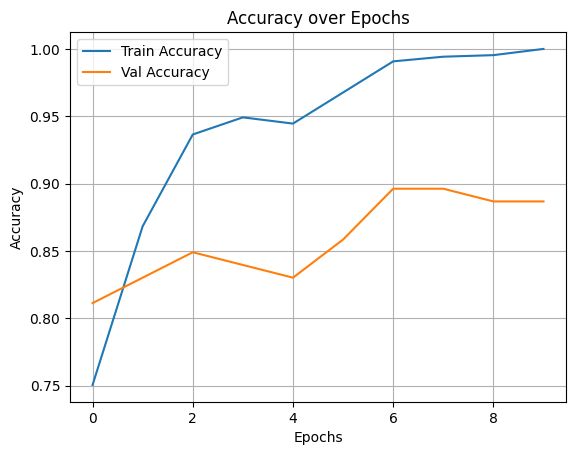

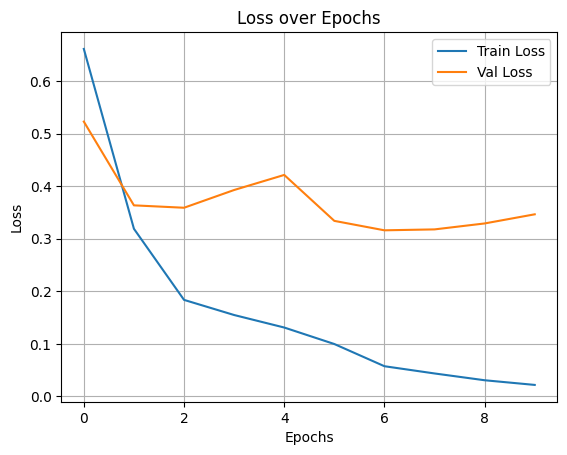

In [ ]:
# STEP 7: Evaluate Model
import matplotlib.pyplot as plt
test_loss, test_accuracy = model.evaluate(test_generator)

# Curves
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


✅ Training Accuracy: 100.00%
✅ Validation Accuracy: 88.68%
✅ Test Accuracy: 89.38%
⏱️ Training Time: 1110.73 seconds
📦 Model Size: 1.51 MB
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step

📊 Classification Report:
                        precision    recall  f1-score   support

           Anthracnose       0.30      0.29      0.30        31
             Basal_Rot       0.00      0.00      0.00         2
Iris_Yellow_Spot_Virus       0.36      0.36      0.36        25
         Purple_Blotch       0.21      0.30      0.25        10
    Stemphylium_Blight       0.21      0.20      0.21        15
                Thrips       0.30      0.30      0.30        30

              accuracy                           0.29       113
             macro avg       0.23      0.24      0.24       113
          weighted avg       0.29      0.29      0.29       113



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


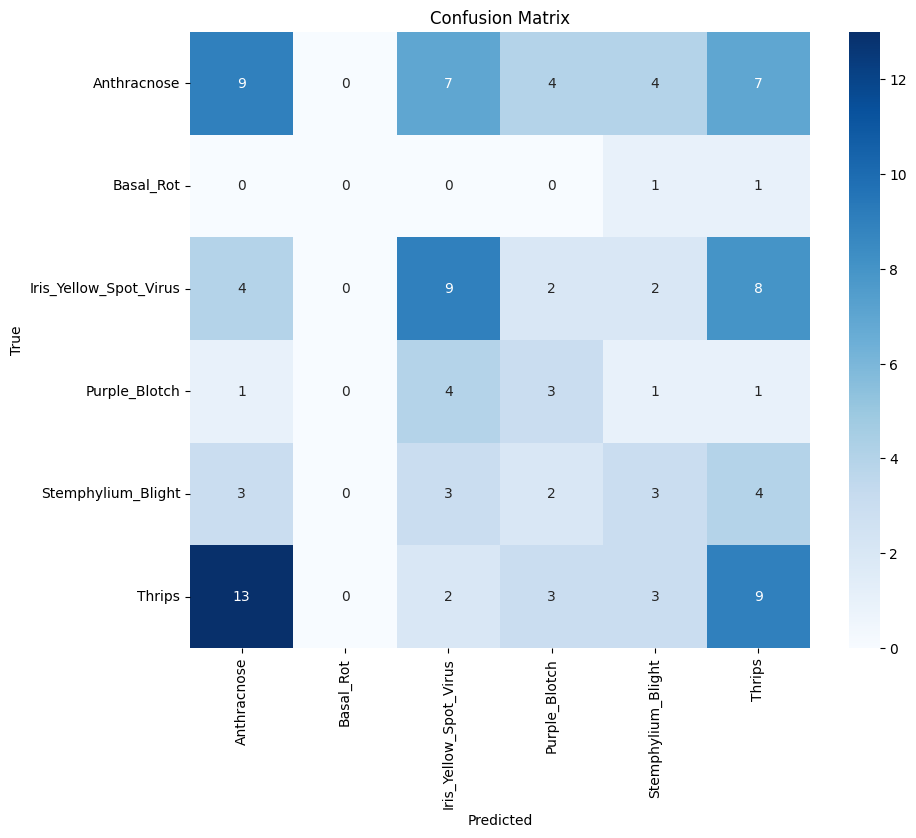

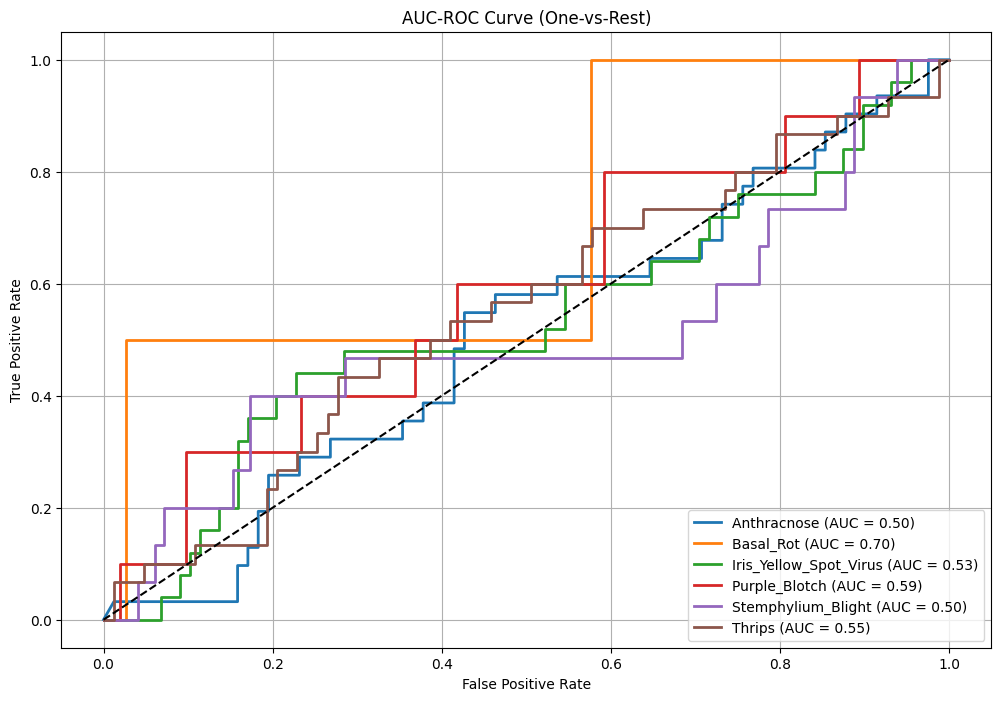

🧮 Macro-average AUC: 0.5617
🧮 Weighted-average AUC: 0.5323


In [ ]:
# STEP 8: Metrics Summary
import numpy as np
model_size = np.sum([np.prod(v.shape) for v in model.trainable_variables])
model_size_MB = model_size * 4 / (1024 ** 2)

print(f"\n✅ Training Accuracy: {history.history['accuracy'][-1] * 100:.2f}%")
print(f"✅ Validation Accuracy: {history.history['val_accuracy'][-1] * 100:.2f}%")
print(f"✅ Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"⏱️ Training Time: {training_time:.2f} seconds")
print(f"📦 Model Size: {model_size_MB:.2f} MB")

# STEP 9: Classification Report & Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns

y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# STEP 10: AUC-ROC Curve
y_true_bin = label_binarize(y_true, classes=range(num_classes))
plt.figure(figsize=(12, 8))
for i, label in enumerate(class_labels):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{label} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("AUC-ROC Curve (One-vs-Rest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Macro AUC
print(f"🧮 Macro-average AUC: {roc_auc_score(y_true_bin, y_pred, average='macro'):.4f}")
print(f"🧮 Weighted-average AUC: {roc_auc_score(y_true_bin, y_pred, average='weighted'):.4f}")